# Imports

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn import metrics

In [3]:
# Notebook Presentation
# pd.options.display.float_format = '{:,.2f}'.format

# Loading the Data

In [4]:
df = pd.read_csv("scraped\mission_launches.csv")
df

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,CASC,"LC-9A, Taiyuan Satellite Launch Center, China","Thu Dec 5, 2024 10:11 GMT+5:30",Long March 6A | G60 Polar Group 03,StatusActive,NaN,Success
1,SpaceX,"SLC-4E, Vandenberg SFB, California, USA","Thu Dec 5, 2024 08:35 GMT+5:30",Falcon 9 Block 5 | Starlink Group 9-14,StatusActive,69.75,Success
2,VKS RF,"Site 43/4, Plesetsk Cosmodrome, Russia","Wed Dec 4, 2024 23:29 GMT+5:30",Soyuz 2.1b | Cosmos 2580,StatusActive,20.00,Success
3,SpaceX,"SLC-40, Cape Canaveral SFS, Florida, USA","Wed Dec 4, 2024 15:43 GMT+5:30",Falcon 9 Block 5 | Starlink Group 6-70,StatusActive,69.75,Success
4,ExPace,"Mobile Launcher Pad, Xichang Satellite Launch ...","Wed Dec 4, 2024 10:16 GMT+5:30",Kuaizhou 1A | Haishao-1,StatusActive,5.80,Success
...,...,...,...,...,...,...,...
6926,US Navy,"LC-18A, Cape Canaveral SFS, Florida, USA","Wed Feb 5, 1958 13:03 GMT+5:30",Vanguard | Vanguard TV3BU,StatusRetired,NaN,Failure
6927,ABMA,"LC-26A, Cape Canaveral SFS, Florida, USA","Sat Feb 1, 1958 09:17 GMT+5:30",Juno I | Explorer 1,StatusRetired,NaN,Success
6928,US Navy,"LC-18A, Cape Canaveral SFS, Florida, USA","Fri Dec 6, 1957 22:14 GMT+5:30",Vanguard | Vanguard TV3,StatusRetired,NaN,Failure
6929,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 3, 1957 08:00 GMT+5:30",Sputnik 8K71PS | Sputnik 2,StatusRetired,NaN,Success


# Pre-Processing

In [5]:
df.head()

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,CASC,"LC-9A, Taiyuan Satellite Launch Center, China","Thu Dec 5, 2024 10:11 GMT+5:30",Long March 6A | G60 Polar Group 03,StatusActive,NaN,Success
1,SpaceX,"SLC-4E, Vandenberg SFB, California, USA","Thu Dec 5, 2024 08:35 GMT+5:30",Falcon 9 Block 5 | Starlink Group 9-14,StatusActive,69.75,Success
2,VKS RF,"Site 43/4, Plesetsk Cosmodrome, Russia","Wed Dec 4, 2024 23:29 GMT+5:30",Soyuz 2.1b | Cosmos 2580,StatusActive,20.00,Success
3,SpaceX,"SLC-40, Cape Canaveral SFS, Florida, USA","Wed Dec 4, 2024 15:43 GMT+5:30",Falcon 9 Block 5 | Starlink Group 6-70,StatusActive,69.75,Success
4,ExPace,"Mobile Launcher Pad, Xichang Satellite Launch ...","Wed Dec 4, 2024 10:16 GMT+5:30",Kuaizhou 1A | Haishao-1,StatusActive,5.80,Success


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6931 entries, 0 to 6930
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Organisation    6931 non-null   object 
 1   Location        6931 non-null   object 
 2   Date            6891 non-null   object 
 3   Detail          6931 non-null   object 
 4   Rocket_Status   6931 non-null   object 
 5   Price           2837 non-null   float64
 6   Mission_Status  6931 non-null   object 
dtypes: float64(1), object(6)
memory usage: 379.2+ KB


## Duplicates

In [7]:
df.drop_duplicates(inplace=True)

## NANs

In [8]:
df.isna().sum().to_frame(name="% of NANs") / df.shape[0] * 100

,% of NANs
Organisation,0.000000
Location,0.000000
Date,0.519781
Detail,0.000000
Rocket_Status,0.000000
Price,59.052844
Mission_Status,0.000000


In [9]:
df.drop(columns=['Price'], inplace=True)
df.dropna(inplace=True)
df.shape

(6890, 6)

Dropping NANs in `Date` and removing `Price` column

## Feature Engineering

### Date

In [10]:
df.Date.head()

0    Thu Dec 5, 2024 10:11 GMT+5:30
1    Thu Dec 5, 2024 08:35 GMT+5:30
2    Wed Dec 4, 2024 23:29 GMT+5:30
3    Wed Dec 4, 2024 15:43 GMT+5:30
4    Wed Dec 4, 2024 10:16 GMT+5:30
Name: Date, dtype: object

In [11]:
df["Date"].replace(to_replace=r'GMT', value="", regex = True, inplace=True)
df["Date"] = pd.to_datetime(df["Date"], format='mixed')
df[["Date"]].head()

,Date
0,2024-12-05 10:11:00+05:30
1,2024-12-05 08:35:00+05:30
2,2024-12-04 23:29:00+05:30
3,2024-12-04 15:43:00+05:30
4,2024-12-04 10:16:00+05:30


In [12]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df["WeekofMonth"] = ((df['Date'].dt.day - 1) // 7 + 1)
df['DayofMonth'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour
df.drop("Date", axis=1, inplace=True)

In [13]:
df.sample()

,Organisation,Location,Detail,Rocket_Status,Mission_Status,Year,Month,WeekofMonth,DayofMonth,DayOfWeek,Hour
2103,Arianespace,"ELA-3, Guiana Space Centre, French Guiana, France",Ariane 5 ECA | JCSAT-10 & Syracuse 3B,StatusRetired,Success,2006,8,2,12,5,3


### Detail

In [14]:
df.head()

,Organisation,Location,Detail,Rocket_Status,Mission_Status,Year,Month,WeekofMonth,DayofMonth,DayOfWeek,Hour
0,CASC,"LC-9A, Taiyuan Satellite Launch Center, China",Long March 6A | G60 Polar Group 03,StatusActive,Success,2024,12,1,5,3,10
1,SpaceX,"SLC-4E, Vandenberg SFB, California, USA",Falcon 9 Block 5 | Starlink Group 9-14,StatusActive,Success,2024,12,1,5,3,8
2,VKS RF,"Site 43/4, Plesetsk Cosmodrome, Russia",Soyuz 2.1b | Cosmos 2580,StatusActive,Success,2024,12,1,4,2,23
3,SpaceX,"SLC-40, Cape Canaveral SFS, Florida, USA",Falcon 9 Block 5 | Starlink Group 6-70,StatusActive,Success,2024,12,1,4,2,15
4,ExPace,"Mobile Launcher Pad, Xichang Satellite Launch ...",Kuaizhou 1A | Haishao-1,StatusActive,Success,2024,12,1,4,2,10


In [15]:
detail_cols = df['Detail'].str.split(r' | ', expand=True, regex=False)
df.drop("Detail", axis=1, inplace=True)

In [16]:
df.insert(3, column='Rocket', value=detail_cols.iloc[:,0])
df.insert(4, column='Mission', value=detail_cols.iloc[:,1])

### Rocket Status

In [17]:
df["Rocket_Status"].value_counts().to_frame()

,count
Rocket_Status,
StatusRetired,5376
StatusActive,1514


In [18]:
df["Rocket_Status"] = df["Rocket_Status"].str.strip(r'Status')

### Location

In [19]:
df["Location"].value_counts().to_frame()

,count
Location,
"Site 1/5, Baikonur Cosmodrome, Kazakhstan",486
"Site 31/6, Baikonur Cosmodrome, Kazakhstan",420
"Site 43/4, Plesetsk Cosmodrome, Russia",327
"Site 41/1, Plesetsk Cosmodrome, Russia",309
"SLC-40, Cape Canaveral SFS, Florida, USA",276
...,...
"K-84 Submarine, Barents Sea Launch Area, Barents Sea",1
"DeBo 3 Barge, China Coastal Waters",1
"Tai Rui Barge (Area 1), China Coastal Waters",1


In [20]:
df["Launch Pad"] = df["Location"].str.extract(r'^([^,]+)')
df["Country"] = df["Location"].str.extract(r'([\w\s]+)$')
df.drop("Location", axis=1, inplace=True)
df[["Launch Pad", "Country"]]

,Launch Pad,Country
0,LC-9A,China
1,SLC-4E,USA
2,Site 43/4,Russia
3,SLC-40,USA
4,Mobile Launcher Pad,China
...,...,...
6926,LC-18A,USA
6927,LC-26A,USA
6928,LC-18A,USA
6929,Site 1/5,Kazakhstan


### Mission_Status: *Target*

In [21]:
df["Mission_Status"].value_counts()

Mission_Status
Success              6324
Failure               445
Partial Failure       116
Prelaunch Failure       5
Name: count, dtype: int64

<Axes: xlabel='Mission_Status'>

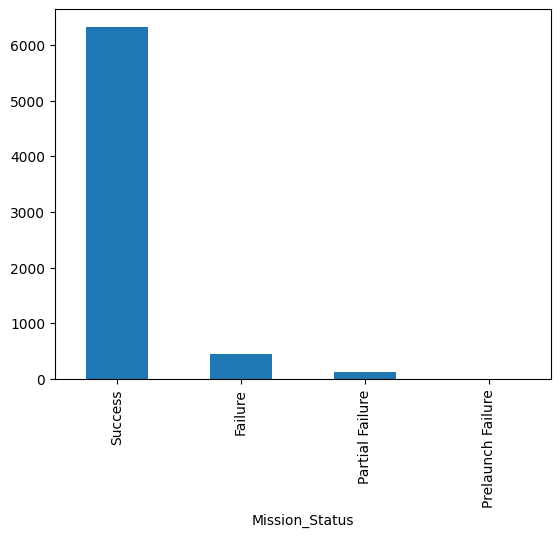

In [22]:
df["Mission_Status"].value_counts().plot(kind='bar')

Classes are extremely imbalanced

In [23]:
df["Mission_Status"] = df["Mission_Status"].replace(
    {
        "Failure": "Not Success",
        "Partial Failure": "Not Success",
        "Prelaunch Failure": "Not Success",
    }
)
df["Mission_Status"].value_counts()

Mission_Status
Success        6324
Not Success     566
Name: count, dtype: int64

## Feature Encoding & Selection

In [24]:
X = df.drop("Mission_Status", axis=1)
y = df["Mission_Status"]

### Mission_Status: *Target*

label encoding (Ordinal)

In [25]:
y.value_counts().to_frame()

,count
Mission_Status,
Success,6324
Not Success,566


In [26]:
mission_stat_encoder = LabelEncoder()
y = mission_stat_encoder.fit_transform(y)
y = pd.Series(y)
y.value_counts().to_frame("Mission_Status")

,Mission_Status
1,6324
0,566


### Rocket_Status

Onehot encoding

In [27]:
X["Rocket_Status"].value_counts().to_frame()

,count
Rocket_Status,
Retired,5376
Active,1514


In [28]:
rckt_stats_enc = OneHotEncoder(sparse_output=False, drop='first')
X["Rocket_Status"] = rckt_stats_enc.fit_transform(X[["Rocket_Status"]])
pd.DataFrame(X["Rocket_Status"]).value_counts().to_frame()


,count
Rocket_Status,
1.0,5376
0.0,1514


### Mission

Ordinal encoding

In [29]:
X["Mission"].value_counts().to_frame()

,count
Mission,
Resurs-F,20
Demo Flight,6
Ōsumi,5
10-Kilometer Test Flight,4
Strela-2M satellite,3
...,...
Intelsat 907,1
DSCS-3 A3,1
"IGS-Optical 1, IGS-Radar 1",1


In [30]:
mission_enc = OrdinalEncoder()
X["Mission"] = mission_enc.fit_transform(X[["Mission"]])
X["Mission"].value_counts().to_frame()

,count
Mission,
5315.0,20
2692.0,6
6836.0,5
6.0,4
6209.0,3
...,...
3678.0,1
2652.0,1
3507.0,1


### Rocket

Ordinal encoding

In [31]:
X["Rocket"].value_counts().to_frame()

,count
Rocket,
Soyuz U,778
Cosmos-3M,445
Falcon 9 Block 5,350
Voskhod,299
Molniya-M/Block ML,128
...,...
Gravity 1,1
Europa 2,1
Delta II 6925-8,1


In [32]:
rocket_enc = OrdinalEncoder()
X["Rocket"] = rocket_enc.fit_transform(X[["Rocket"]])
X["Rocket"].value_counts().to_frame()

,count
Rocket,
362.0,778
88.0,445
172.0,350
431.0,299
255.0,128
...,...
177.0,1
166.0,1
121.0,1


### Location

Ordinal encoding

Launch pad

In [33]:
X["Launch Pad"].value_counts().to_frame()

,count
Launch Pad,
Site 1/5,486
Site 31/6,420
Site 43/4,327
Site 41/1,309
SLC-40,276
...,...
K-496 Submarine,1
K-407 Submarine,1
Site 175/58,1


In [34]:
launch_pad_enc = OrdinalEncoder()
X["Launch Pad"] = launch_pad_enc.fit_transform(X[["Launch Pad"]])
X["Launch Pad"].value_counts().to_frame()

,count
Launch Pad,
100.0,486
124.0,420
132.0,327
129.0,309
87.0,276
...,...
18.0,1
17.0,1
116.0,1


Country

In [35]:
X["Country"].value_counts().to_frame()

,count
Country,
USA,2164
Russia,1812
Kazakhstan,1556
China,624
France,326
Japan,137
India,94
New Zealand,51
Pacific Ocean,36


In [36]:
country_enc = OrdinalEncoder()
X["Country"] = country_enc.fit_transform(X[["Country"]])
X["Country"].value_counts().to_frame()

,count
Country,
20.0,2164
18.0,1812
11.0,1556
3.0,624
5.0,326
10.0,137
7.0,94
14.0,51
17.0,36


### Organisation

Ordinal encoding

In [37]:
X["Organisation"].value_counts().to_frame()

,count
Organisation,
RVSN USSR,2464
US Air Force,546
CASC,493
SpaceX,434
Roscosmos,374
...,...
Space Pioneer,1
Orienspace,1
OKB-586,1


In [38]:
org_enc = OrdinalEncoder()
X["Organisation"] = org_enc.fit_transform(X[["Organisation"]])
X["Organisation"].value_counts().to_frame()

,count
Organisation,
50.0,2464
63.0,546
12.0,493
60.0,434
53.0,374
...,...
59.0,1
48.0,1
46.0,1


## Train-Test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Modelling: RandomForest

In [40]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
rfc.score(X_test, y_test)

0.9280325014509576

In [42]:
y_pred_test = rfc.predict(X_test)

## Confusion Matrix

Confision matrix on Testing data

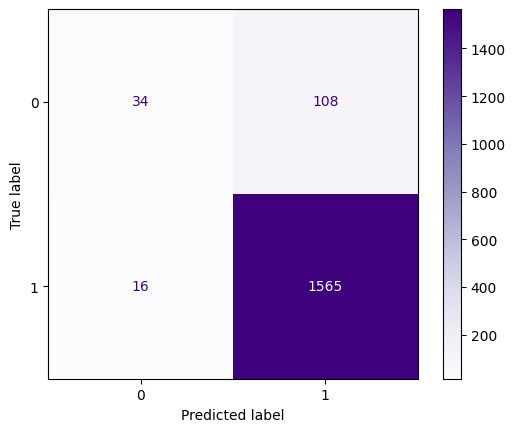

In [43]:
cm_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=rfc.classes_)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=rfc.classes_).plot(cmap='Purples')
plt.grid(False)
plt.show()

Metrics on Testing data

In [44]:
metrics.accuracy_score(y_test, y_pred_test)

0.9280325014509576

## Classification Report

In [45]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.24      0.35       142
           1       0.94      0.99      0.96      1581

    accuracy                           0.93      1723
   macro avg       0.81      0.61      0.66      1723
weighted avg       0.91      0.93      0.91      1723



## ROC & AUC

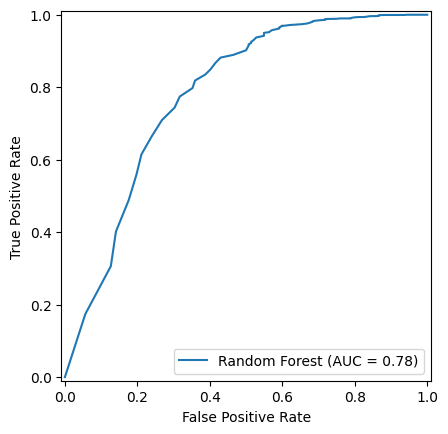

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Random Forest"
)

display.plot()
plt.show()

# Modelling: AdaBoost

*On Decison Tree*

In [47]:
adaBoost_clf = AdaBoostClassifier()

In [48]:
adaBoost_clf.fit(X_train, y_train)

AdaBoostClassifier()

In [49]:
adaBoost_clf.score(X_test, y_test)

0.914683691236216

In [50]:
y_pred_test = adaBoost_clf.predict(X_test)

## Confusion Matrix

Confision matrix on Testing data

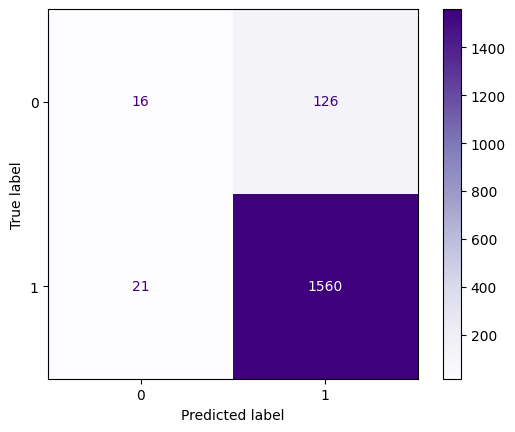

In [51]:
cm_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=adaBoost_clf.classes_)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=adaBoost_clf.classes_).plot(cmap='Purples')
plt.grid(False)
plt.show()

Metrics on Testing data

In [52]:
metrics.accuracy_score(y_test, y_pred_test)

0.914683691236216

## Classification Report

In [53]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.43      0.11      0.18       142
           1       0.93      0.99      0.96      1581

    accuracy                           0.91      1723
   macro avg       0.68      0.55      0.57      1723
weighted avg       0.88      0.91      0.89      1723



## ROC & AUC

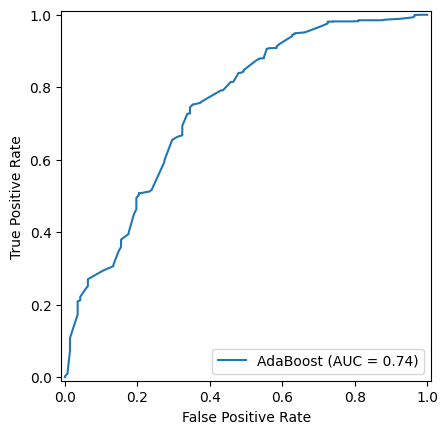

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, adaBoost_clf.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="AdaBoost"
)

display.plot()
plt.show()

# Cross-Validation:

*Hyperparameter tuning*

In [55]:
param_grid = {
    "n_estimators": [5, 10, 25, 50, 100, 500],
    "learning_rate": [1, 0.0001, 0.001, 0.1, 0.5, 1.0],
}

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
adaboost_grid = GridSearchCV(adaBoost_clf, param_grid, cv=10, n_jobs=-1)

In [58]:
adaboost_grid.fit(X, y)

GridSearchCV(cv=10, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [1, 0.0001, 0.001, 0.1, 0.5, 1.0],
                         'n_estimators': [5, 10, 25, 50, 100, 500]})

In [59]:
best_params = adaboost_grid.best_params_
best_params

{'learning_rate': 1, 'n_estimators': 5}

In [60]:
adaBoost_clf_best = AdaBoostClassifier(learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'])

In [61]:
acc_cv_score = cross_val_score(adaBoost_clf_best, X, y, scoring='accuracy', cv=10)
acc_cv_score.mean()

0.8359941944847605

In [62]:
cv_scores = cross_validate(
    adaBoost_clf_best, X, y, cv=10, scoring=("accuracy", "balanced_accuracy", "precision", "recall", "f1"), return_train_score=False, n_jobs=-1
)

In [63]:
pd.DataFrame(cv_scores).describe()

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.069145,0.020579,0.835994,0.500870,0.926125,0.901741,0.864903
std,0.021973,0.010273,0.259062,0.002752,0.025967,0.310724,0.291874
min,0.047400,0.011032,0.098694,0.500000,0.917271,0.017405,0.034215
25%,0.051569,0.012421,0.917271,0.500000,0.917271,1.000000,0.956851
50%,0.065139,0.018761,0.917271,0.500000,0.917997,1.000000,0.956851
75%,0.080817,0.023352,0.918723,0.500000,0.918723,1.000000,0.957640
max,0.115637,0.043238,0.918723,0.508703,1.000000,1.000000,0.957640


In [64]:
adaBoost_clf_best.fit(X, y)

AdaBoostClassifier(learning_rate=1, n_estimators=5)

In [65]:
y_pred = adaBoost_clf_best.predict(X)

In [66]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.13      0.21       566
           1       0.93      0.99      0.96      6324

    accuracy                           0.92      6890
   macro avg       0.72      0.56      0.58      6890
weighted avg       0.89      0.92      0.90      6890

